# License Plate Detection with OpenCV

In this project we demonstrate how to use OpenCV only, with traditional computer vision approaches, to perform License Plate Detection (LPD). 

We follow two approaches:

1- __Morphology based approach__: where only morphological transforms are used, along with some rules to detect the LP.

2- __Charater based approach__: in addition to basic morphological approaches, basic char detection, also based on morphology, is used as an extra characteristic of the LP.

Further, the problem of Licence Plate Recognition (LPR), by recognizing the number and digits written, can be addressed by the second approach.

In both approaches, we load HD videos (1080p). Due to the camera position, this is the most effective resolution to detect LP patterns.

In both approaches we merge car detection, using background subtraction, to narrow the search space.

# Pre-requisites

You need to install the packages in `requirements.txt`:
    
`pip install -r requirements.txt`

In [1]:

import numpy as np
import cv2
import imutils
import os
from tqdm import tqdm
import matplotlib.pyplot as plt



In [2]:
# Project constants
SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)

In [3]:
# Helper functions

def plot_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def draw_oriented_bbox(frame, bbox):
    # Oriented
    rotrect = cv2.minAreaRect(bbox)
    center, size, theta = rotrect
    box = cv2.boxPoints(rotrect)
    box = np.int0(box)
    cv2.drawContours(frame, [box], 0, SCALAR_RED, 10)

# Moving object detection (MOD)

In this part, we show how to detect and isolate the car box. 

We use background subtraction. [See this reference](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/). This is possible due to the fixed camera position.

We can detect bounding rectangle or oriented one. The oriented bbox is not very accurate, and later it turns to be not important for LPD.

In [4]:

def detect_cars(frame, background):
    MIN_AREA = 10000
    cars = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    # compute the absolute difference between the current frame and
    # first frame
    frame_delta = cv2.absdiff(background, gray)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # loop over the contours
    for k,c in enumerate(cnts):
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < MIN_AREA:
            continue
        car = cv2.boundingRect(c)
        cars.append(car)
    return cars

## Video processing
The `process_video` function takes car of frame processing of the given `video_file`. The output is saved in the location of the output `video_output_file`.

This function can be used to:
- Detect Moving cars.
- Detect LPs within car frames, and plot it back in the original frame.
- Detect LPs in the big frame directly.

In [5]:
def make_1080p(cap):
    cap.set(3, 1920)
    cap.set(4, 1080)

def make_720p(cap):
    cap.set(3, 1280)
    cap.set(4, 720)

def make_480p(cap):
    cap.set(3, 640)
    cap.set(4, 480)

def change_res(width, height):
    cap.set(3, width)
    cap.set(4, height)


def process_video(video_file, # The video path to be processed
                  video_output_file, # The output video file
                  output_video_resolution=(640,480), # The desired output resolution
                  frames_cnt=None, # The desired number of frames to process. If None the whole video is processed.
                  cars_detection=True, # LPD will work on the car cropped image or whole image.
                  show_cars_bbox=0,# 0=dont show, 1: show rect, 2: show oriented bbox.
                  detect_LP_fn=None, # The LPD function.
                  debug=False):

    	

    # Set input capture to 1080p
    cap = cv2.VideoCapture(video_file)
    make_1080p(cap)
    
    # Set the frame count if no passed desired number process the whole video
    if frames_cnt == None: frames_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Prepare the output video file
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(video_output_file,fourcc, 20.0, output_video_resolution)

    # The min detectable car is a 100x100 rectangle
    MIN_AREA = 10000
    
    # Set the back ground frame to nothing
    background = None


    for cnt in tqdm(range(frames_cnt), position=0, leave=True):

        ret, frame = cap.read() 

        if ret:
            if cars_detection:

                if background is None:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    gray = cv2.GaussianBlur(gray, (21, 21), 0)
                    # if the first frame is None, initialize it
                    background = gray
                    continue
                    
                cars = detect_cars(frame, background)
                for car in cars:
                    
                    (x, y, w, h) = car
                    car = frame[y:y+h,x:x+w,:]
                    if debug: print('Car size', car.shape)                        
                    if detect_LP_fn != None:
                        # Pass the cropped car image to LPD
                        car_LP, LPs = detect_LP(car, debug)
                        # Put back the LP patch in the original frame
                        frame[y:y+h,x:x+w,:] = car_LP

                    if show_cars_bbox == 1: # Just rectangle
                        cv2.rectangle(frame, (x, y), (x + w, y + h), SCALAR_RED, 10)
                    elif show_cars_bbox == 2: # Oriented rectangle
                        draw_oriented_bbox(frame, c)
            
            elif detect_LP_fn != None:
                frame, LPs = detect_LP_fn(frame, debug)
                

            if debug: plot_img(frame)
            out.write(cv2.resize(frame, output_video_resolution))
        else:
            print('no video')
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        

    cap.release()
    out.release()
    print('Video is ready at: ', video_output_file)

In [6]:
video_file = 'dat/detection_test.mp4'
video_output_file = 'dat/cars_detection.mp4'
#process_video(video_file, video_output_file, show_cars_bbox=1)

# Morphology based approach

This approach is based on applying morphological operations to emphasasize the LP pattern. Mainly, two main patters:
- Edge of bright area
- Rectangular shape

As usual with rule based approaches, we suffer sensitivity to parameters settings. To make it less critical we perform two simple tricks:
- Apply the rules only on the car patches, thanks to the car detection step.
- Resize into standard size makes it easier to set global rules, with less sensitivity to scale. This is also possible thanks to the car detection step.

In this approach we follow the following steps:

- Resize frame to standard size.
- Transform frame into gray scale.
- Adaptive thresholding.
- Canny edge detection.
- Dilation loop (3 iteration, 3x3 kernel).
- Contours on dialted image.
- Get candidate plates by fitting oriented bbox around contours.
- Filter the candidate LPs with rules on L,W of the oriented bbox. 
- Resize the frame back into the original size



In [7]:
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 40

def extractValue(img):
    height, width, numChannels = img.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, img = cv2.split(img)

    return img
def maximizeContrast(gray):

    height, width = gray.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat
# Denosing + Gray + Thresholding
def preprocess(img):
    
    gray = extractValue(img)

    gray = maximizeContrast(gray)
    

    height, width = gray.shape

    blurred = np.zeros((height, width, 1), np.uint8)

    blurred = cv2.GaussianBlur(gray, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #blurred = cv2.GaussianBlur(gray, (21, 21), 0)

    #thresh = cv2.adaptiveThreshold(blurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
    thresh = cv2.adaptiveThreshold(blurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
    return thresh

In [8]:
SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)


def detect_LP_morpho(img, L_min=0, L_max=1000, W_min=0, W_max=1000, debug=False):

    min_canny = 100
    max_canny = 200
    dilation_type = cv2.MORPH_RECT #cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS

    
    thresh = preprocess(img)
    if debug: plot_img(thresh)
    
    edges = cv2.Canny(thresh,100,200)
    if debug: plot_img(edges)
    
    kernel_sz = 3
    iterations = 2
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_sz, kernel_sz))
    dilated = cv2.dilate(edges, structuringElement, iterations=iterations)
    
    
    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    candidates = []

    for c in contours:
        rotrect = cv2.minAreaRect(c)
        center, size, theta = rotrect
        L, W = min(size), max(size)
  
            
        if L >= L_min and L <= L_max and W >= W_min and W <= W_max:
            #rec = rotrect
            candidates.append(rotrect)
            box = cv2.boxPoints(rotrect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, SCALAR_GREEN, 2)
            
            if debug:
                text = 'L=' + str(int(L)) + ', W=' + str(int(W))
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = float(L) / 40.0                    # base font scale on height of plate area
                thickness = int(round(scale * 1.5))
                color = SCALAR_YELLOW
                cv2.putText(img, text, (int(center[0]-L/2), int(center[1]-W/2)), font, scale, color, thickness)
                #cv2.putText(img, text,  (0,10), font, int(scale), color, int(thickness))
    
    if debug: plot_img(dilated)
        
    #print(rec)
    return img, candidates


In [9]:
def detect_LP(img, debug):
    sz = (img.shape[1], img.shape[0]) 
    car_LP, LPs = detect_LP_morpho(cv2.resize(img, (500,500)), L_min=35, L_max=60, W_min=55, W_max=120, debug=debug)
    car_LP = cv2.resize(car_LP, sz)
    return car_LP, LPs

## Calibrating the rules
In this section we use sample images captured from the test video in order to calibrate the min and max L and W of the plate detection.

We set `debug=True` in order to see the intermediate results (thresholding, edges, dilation).

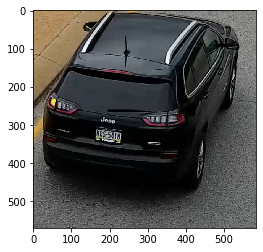

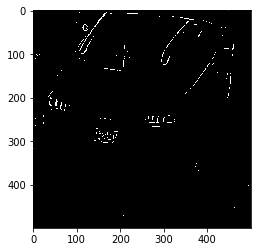

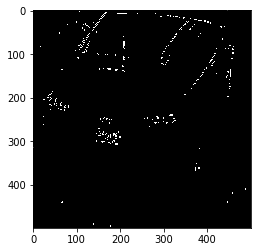

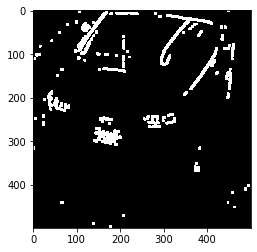

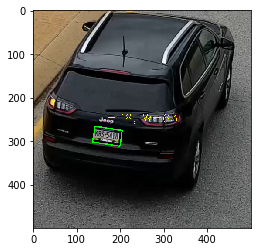

In [10]:
img  = cv2.imread("imgs/char_frame_180_car_no_lp1.png")
plot_img(img)
detected_img, LPs = detect_LP_morpho(cv2.resize(img, (500,500)), L_min=35, L_max=60, W_min=55, W_max=90, debug=True)
plot_img(detected_img)

In [11]:
video_file = 'dat/detection_test.mp4'
video_output_file = 'dat/morpho_LP_detection.mp4'
#process_video(video_file, video_output_file, detect_LP_fn=detect_LP)

We notice the following problems:
- Many false positives
- Rules apply to disoriented false contours
- Aggeessive dilation make bigger rectangles in some cases


It is recommended:
- Integrate a tracker to smooth the false positives (TBD).
- Add more features of LP, like characters, which we will do next.

# Character based approach

The main approach in this part is imported from this nice git [repo](https://github.com/MicrocontrollersAndMore/OpenCV_3_License_Plate_Recognition_Python.git) Code is copied here just for self contained repo, with minor changes.


The approach shares the same preprocessing steps as in the morphological approach above.

However, we integrate extra features, which is char detection. This facilitates the filtering out operation, instead of only relying on the L, W rules.

The downside is that, we now depend on the language of the sign. For different languages, we need different char detector, which is not a bi issue.

In [12]:
import char.DetectChars
import char.DetectPlates
import char.PossiblePlate

def drawRectangleAroundPlate(imgOriginalScene, licPlate):
    
    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)            # get 4 vertices of rotated rect

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_GREEN, 2)         # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_GREEN, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_GREEN, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_GREEN, 2)
    
def writeLicensePlateCharsOnImage(imgOriginalScene, licPlate):
    ptCenterOfTextAreaX = 0                             # this will be the center of the area the text will be written to
    ptCenterOfTextAreaY = 0

    ptLowerLeftTextOriginX = 0                          # this will be the bottom left of the area that the text will be written to
    ptLowerLeftTextOriginY = 0

    sceneHeight, sceneWidth, sceneNumChannels = imgOriginalScene.shape
    plateHeight, plateWidth, plateNumChannels = licPlate.imgPlate.shape

    intFontFace = cv2.FONT_HERSHEY_SIMPLEX                      # choose a plain jane font
    fltFontScale = float(plateHeight) / 30.0                    # base font scale on height of plate area
    intFontThickness = int(round(fltFontScale * 1.5))           # base font thickness on font scale

    textSize, baseline = cv2.getTextSize(licPlate.strChars, intFontFace, fltFontScale, intFontThickness)        # call getTextSize

            # unpack roatated rect into center point, width and height, and angle
    ( (intPlateCenterX, intPlateCenterY), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg ) = licPlate.rrLocationOfPlateInScene

    intPlateCenterX = int(intPlateCenterX)              # make sure center is an integer
    intPlateCenterY = int(intPlateCenterY)

    ptCenterOfTextAreaX = int(intPlateCenterX)         # the horizontal location of the text area is the same as the plate

    if intPlateCenterY < (sceneHeight * 0.75):                                                  # if the license plate is in the upper 3/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) + int(round(plateHeight * 1.6))      # write the chars in below the plate
    else:                                                                                       # else if the license plate is in the lower 1/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) - int(round(plateHeight * 1.6))      # write the chars in above the plate
    # end if

    textSizeWidth, textSizeHeight = textSize                # unpack text size width and height

    ptLowerLeftTextOriginX = int(ptCenterOfTextAreaX - (textSizeWidth / 2))           # calculate the lower left origin of the text area
    ptLowerLeftTextOriginY = int(ptCenterOfTextAreaY + (textSizeHeight / 2))          # based on the text area center, width, and height

            # write the text on the image
    cv2.putText(imgOriginalScene, licPlate.strChars, (ptLowerLeftTextOriginX, ptLowerLeftTextOriginY), intFontFace, fltFontScale, SCALAR_YELLOW, intFontThickness)
# end function
    

In [13]:
import char.Preprocess
char.Preprocess.ADAPTIVE_THRESH_WEIGHT = 19
def detect_LP_char(frame, L_min=0, L_max=50, W_min=0, W_max=150, debug=False):
    blnKNNTrainingSuccessful = char.DetectChars.loadKNNDataAndTrainKNN()         # attempt KNN training

    if blnKNNTrainingSuccessful == False:                               # if KNN training was not successful
        print("\nerror: KNN traning was not successful\n")  # show error message
        return frame, None                                                          # and exit program
    # end if

    #imgOriginalScene  = cv2.imread("LicPlateImages/1.png")               # open image

    if frame is None:                            # if image was not read successfully
        print("\nerror: image not read from file \n\n")  # print error message to std out
        return frame, None                                             # and exit program
    # end if

    listOfPossiblePlates = char.DetectPlates.detectPlatesInScene(frame)           # detect plates

    listOfPossiblePlates = char.DetectChars.detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates


    if len(listOfPossiblePlates) == 0:                          # if no plates were found
        if debug: print("\nno license plates were detected\n")  # inform user no plates were found
        return frame, None
    else:                                                       # else
        # if we get in here list of possible plates has at leat one plate

        # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
        listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

        # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
        licPlate = listOfPossiblePlates[0]
        #plot_img(licPlate.imgPlate)

        if  len(licPlate.strChars) == 0:                     # if no chars were found in the plate
            if debug: print("\nno characters were detected\n\n")  # show message
            return frame,None                                        # and exit program
        # end if
        if licPlate.imgPlate.shape[0] < L_max and  licPlate.imgPlate.shape[1] < W_max:
            drawRectangleAroundPlate(frame, licPlate)             # draw red rectangle around plate

        #print("\nlicense plate read from image = " + licPlate.strChars + "\n")  # write license plate text to std out
        #print("----------------------------------------")

        #writeLicensePlateCharsOnImage(frame, licPlate)           # write license plate text on the image
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame, licPlate

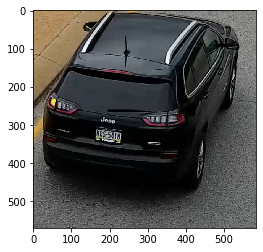

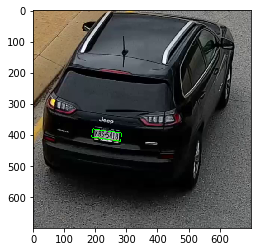

In [14]:
img  = cv2.imread("imgs/char_frame_180_car_no_lp1.png")
plot_img(img)
detected_img, LPs = detect_LP_char(cv2.resize(img, (700,700)),  L_min=0, L_max=50, W_min=0, W_max=150, debug=True)
plot_img(detected_img)

In [15]:
def detect_LP(img, debug):
    sz = (img.shape[1], img.shape[0]) 
    car_LP, LPs = detect_LP_char(cv2.resize(img, (700,700)),  L_min=0, L_max=50, W_min=0, W_max=150, debug=debug)
    car_LP = cv2.resize(car_LP, sz)
    return car_LP, LPs

In [16]:
video_file = 'dat/detection_test.mp4'
video_output_file = 'dat/char_LP_detection.mp4'
process_video(video_file, video_output_file, detect_LP_fn=detect_LP)

100%|██████████| 2171/2171 [03:36<00:00, 10.02it/s]

Video is ready at:  dat/char_LP_detection.mp4


The effect of adding the characters detection feature is clear in filtering out false positive.

# Effect of MOD
Now we will run the same approach, but on the whole frame, instead of detecting the car first

In [17]:
video_file = 'dat/detection_test.mp4'
video_output_file = 'dat/char_LP_detection_without_car_detection.mp4'
process_video(video_file, video_output_file, detect_LP_fn=detect_LP, cars_detection=False)

100%|██████████| 2171/2171 [03:58<00:00,  9.09it/s]

Video is ready at:  dat/char_LP_detection_without_car_detection.mp4


Again, lots of false positives detected. This shows the effect of detecting the moving cars as a preprocessing step.

In the final video, you might now see any detected plates, since they are all filtered out by the internal rules.

# References
- https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/
- https://sod.pixlab.io/articles/license-plate-detection.html
- https://github.com/MicrocontrollersAndMore/OpenCV_3_License_Plate_Recognition_Python.git